# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
print('Размер датасета 0:', df0.shape)
print('Размер датасета 1:', df1.shape)
print('Размер датасета 2:', df2.shape)

Размер датасета 0: (100000, 5)
Размер датасета 1: (100000, 5)
Размер датасета 2: (100000, 5)


Изучим датасеты

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных нет.

In [7]:
df0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Во всех колонках медиана почти равна среднему, что может говорить о нормальном распределении данных, посмотрим далее по графикам.

In [8]:
df1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


В колонках 'f0' и 'f1' медиана почти равна среднему, в 'f2' и 'product' среднее больше медианы что может говорить о скошенности данных вправо.

In [9]:
df2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Данные в 'f0' и 'f1' похожи между собой. Медиана и средняя близки к нулю, почти такие же только с обратным знаком.
В 'f2' и 'product' медиана почти равна среднему, что может говорить о нормальном распределении данных.

Признаки значимы, но неизвестно что они обозначают, поэтому сложно понять нормален ли разброс значений в колонках

In [10]:
df0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [11]:
df1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [12]:
df2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
#проверим данные на наличие дубликатов.
df0.duplicated().sum()

0

In [14]:
df1.duplicated().sum()

0

In [15]:
df2.duplicated().sum()

0

In [16]:
#проверим данные на наличие уникальность.
df0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [17]:
df1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [18]:
df1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

Странная ситуация, только 12 уникальных значений. Как будто это 12 скважин, но id почти все разные. Раз данные синтетические, видимо получены с помощью какого-то алгоритма. Посмотрим как эти данные покажут себя при дальнейшем анализе.

In [19]:
df2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Есть несколько неуникальных id, но признаки у них разные, возможно проводились какие-то измерения у одних и тех же скважин.

Дубликатов в данных нет.

In [20]:
#Построим графики чтобы посмотреть на распределение
def dist_and_box(df,col):
    global title
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'DataFrame №{title}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'DataFrame №{title}',fontsize=20);  

Исследуем данные на графиках

Датасет №0

In [21]:
df = df0
title = '0'

In [22]:
# приведем таблицу для наглядности еще раз
df.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


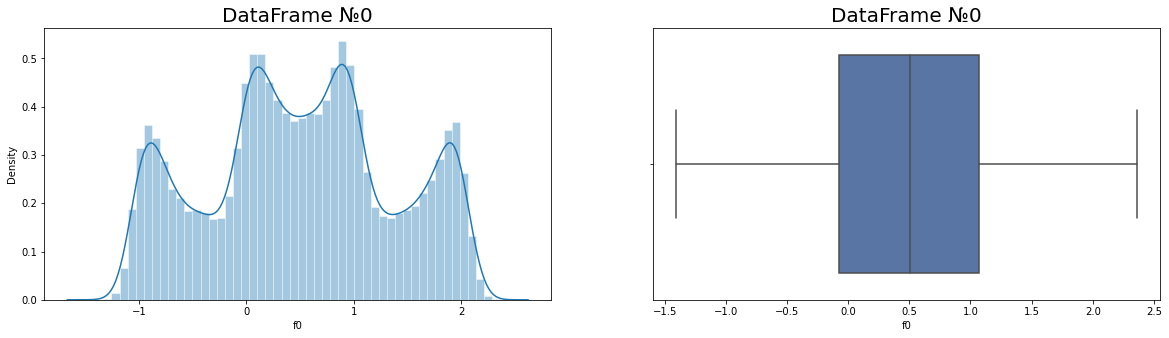

In [23]:
dist_and_box(df,'f0')

Первый признак "f0" имеет 4 пика. Пики в районе -1, 0, 1 и 2. Медиана 0.5

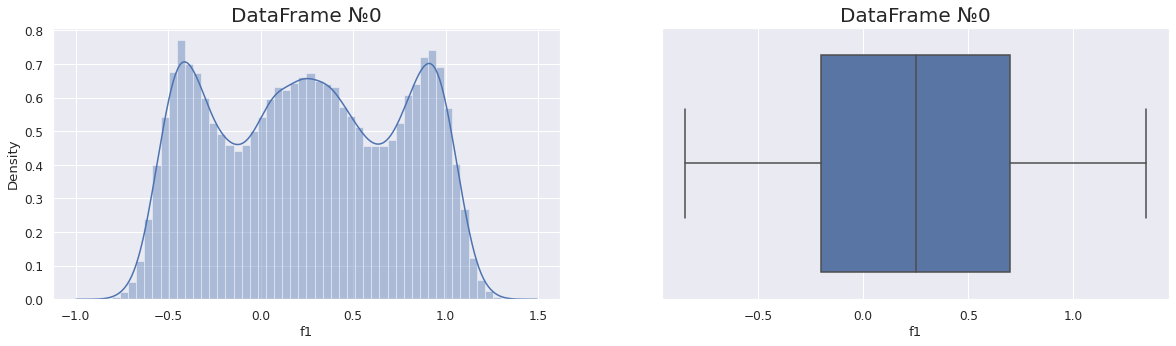

In [24]:
dist_and_box(df,'f1')

Второй признак "f1" имеет 3 пика. Пики в районе -0.5, 0.25, и 1. Медиана 0.25

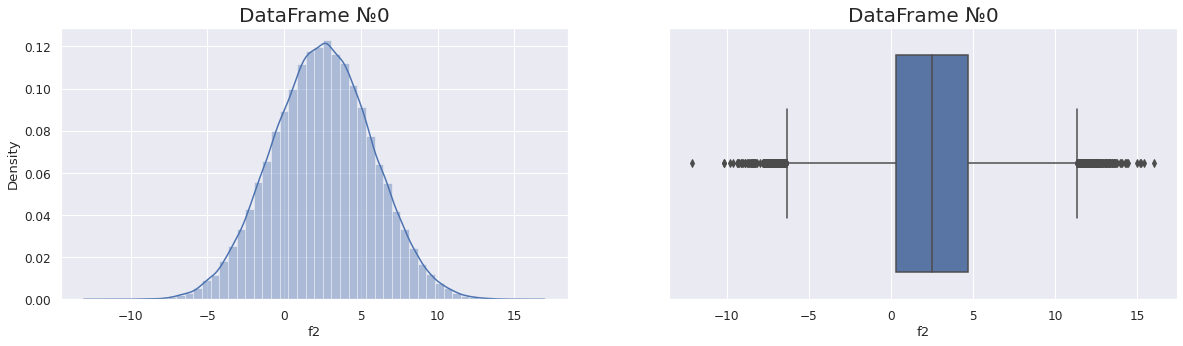

In [25]:
dist_and_box(df,'f2')

Столбец "f2" имеет нормальное распределение с медианой 2.5. И так же наблюдаются выбросы.

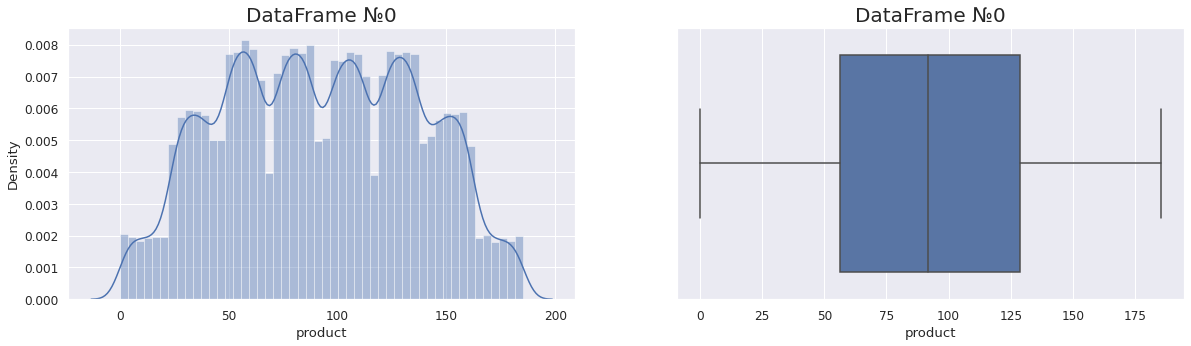

In [26]:
dist_and_box(df,'product')

Столбец "product" имеет 4 пика и два поменьше. По предварительному визуальному осмотру данных, можно предположить, что в районе сбора данные есть несколько тысяч перспективных скважин.

Посмотрим на корреляцию

In [27]:
df.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


"f2" и "product" имеют среднюю 0.483663 (если округлить) корреляцию
"f0" и "f1" имеют слабую -0.440723, но ближе к средней корреляцию

In [28]:
#можно визуализировать, но выполняется ооочень долго
#sns.pairplot(data=df0, hue = 'product');

"f2" и "product" имеют среднюю 0.483663 (если округлить) корреляцию
"f0" и "f1" имеют слабую -0.440723, но ближе к средней корреляцию

Датасет №1

In [29]:
df = df1
title = '1'

In [30]:
# приведем таблицу для наглядности еще раз
df.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


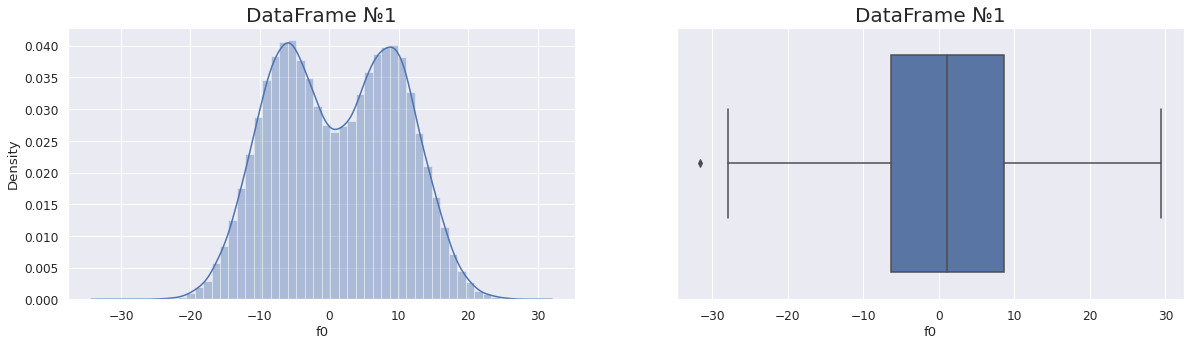

In [31]:
dist_and_box(df,'f0')

Первый признак "f0" имеет 2 пика. Пики в районе -10, и 10. Медиана 1. И отрицательные выбросы.

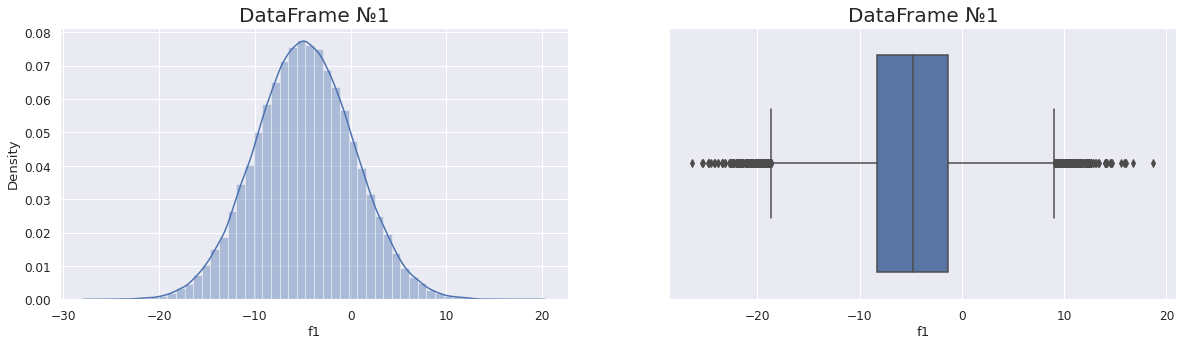

In [32]:
dist_and_box(df,'f1')

Столбец "f1" имеет нормальное распределение с медианой -4.8. И так же наблюдаются выбросы.

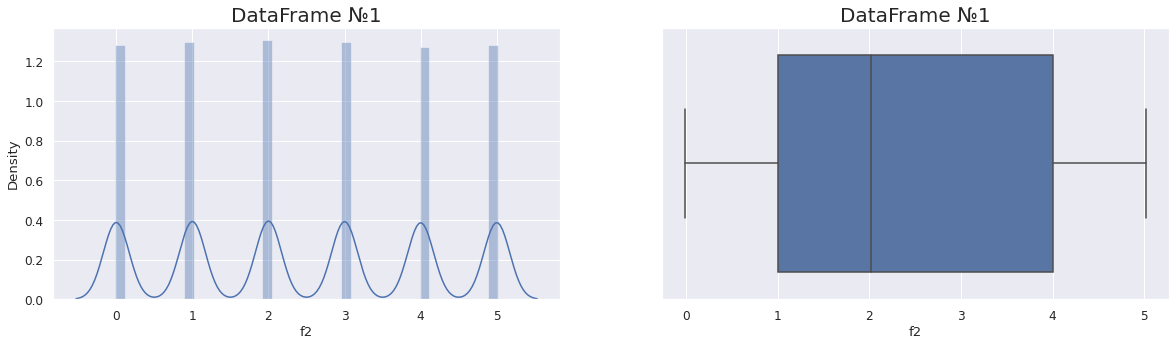

In [33]:
dist_and_box(df,'f2')

Столбец "f2" в датафрейме судя по ящику с усами имеет скос вправо, медиана равна 2. А график имеет довольно странный вид, но это не удивительно так как в датасете всего 12 уникальных значений.

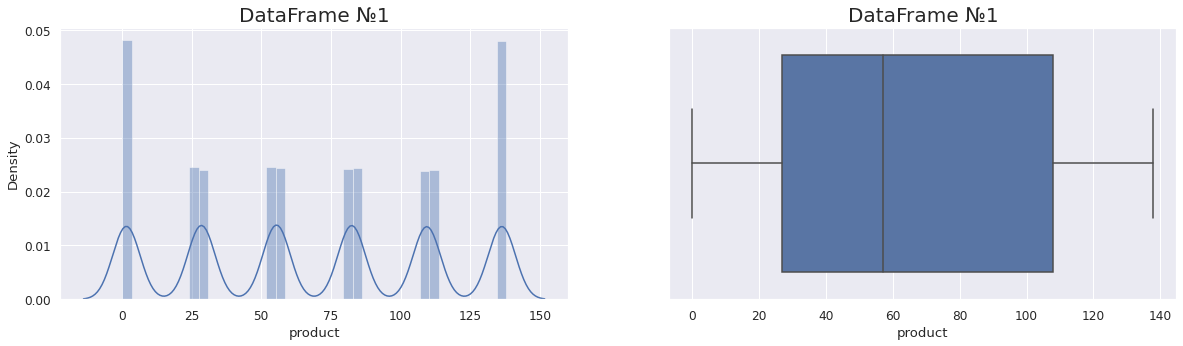

In [34]:
dist_and_box(df,'product')

По предварительному визуальному осмотру, можно предположить, что в районе сбора данные есть несколько тысяч перспективных скважин с мощностью около 130 тыс. баррелей.

Посмотрим на корреляцию

In [35]:
df.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [36]:
#можно визуализировать, но выполняется ооочень долго
#sns.pairplot(data=df1, hue = 'product');

"f0" и "f1" имеют очень слабую 0.182287 корреляцию (но в предыдущем прокте мы обращали внимание и на корреляцию 0,11)
"f2" и "product" имеют очень высокую 0.999397 корреляцию, так как уникальных значений 12 и "f2" имеет маленький разброс значений от 0 до 5.

Датасет №2

In [37]:
df = df2
title = '2'

In [38]:
# приведем таблицу для наглядности еще раз
df.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


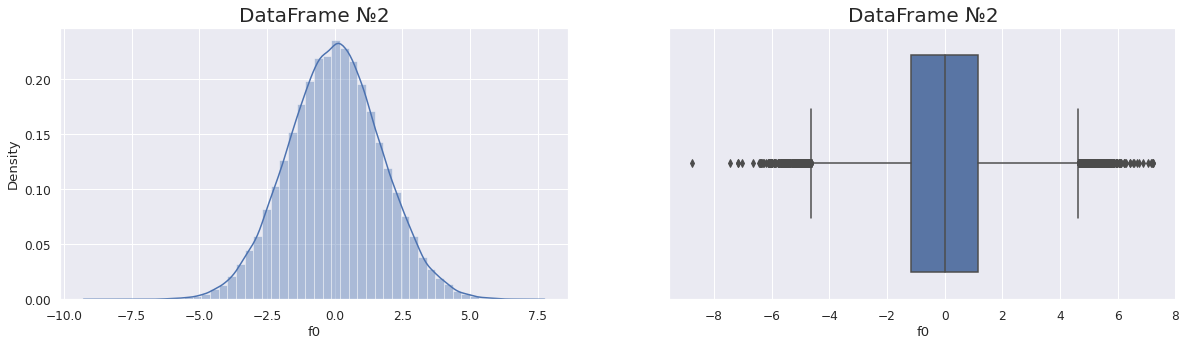

In [39]:
dist_and_box(df,'f0')

Столбец "f0" имеет нормальное распределение с медианой в районе нуля. И так же наблюдаются выбросы.

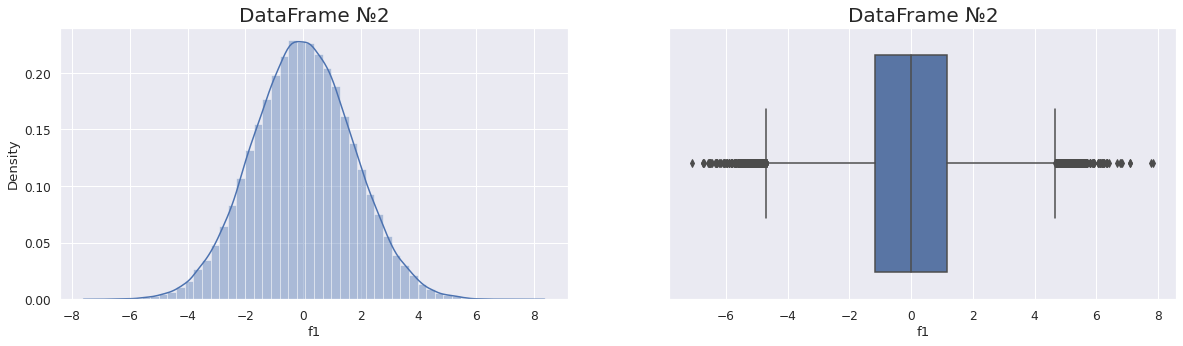

In [40]:
dist_and_box(df,'f1')

Столбец "f1" имеет нормальное распределение с медианой в районе нуля с отрицательной стороны. И так же наблюдаются выбросы. Графики "f0" и "f1" похожи визуально.

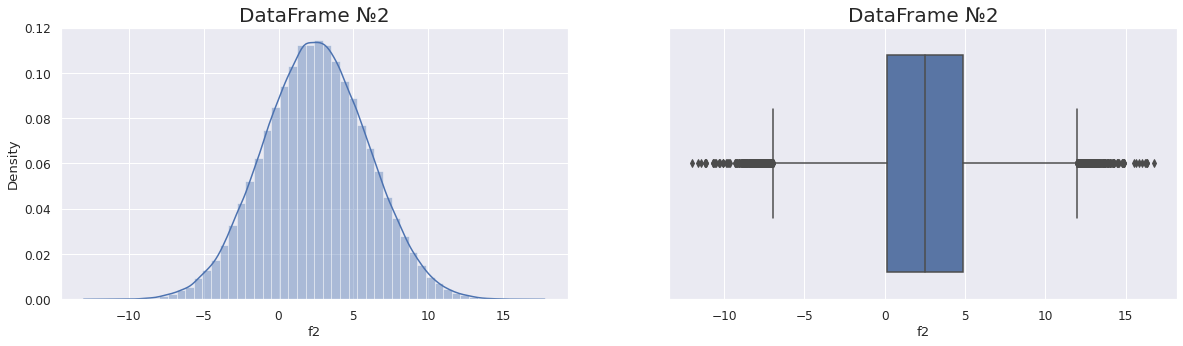

In [41]:
dist_and_box(df,'f2')

Столбец "f2" имеет нормальное распределение с медианой в окресностях 2.5

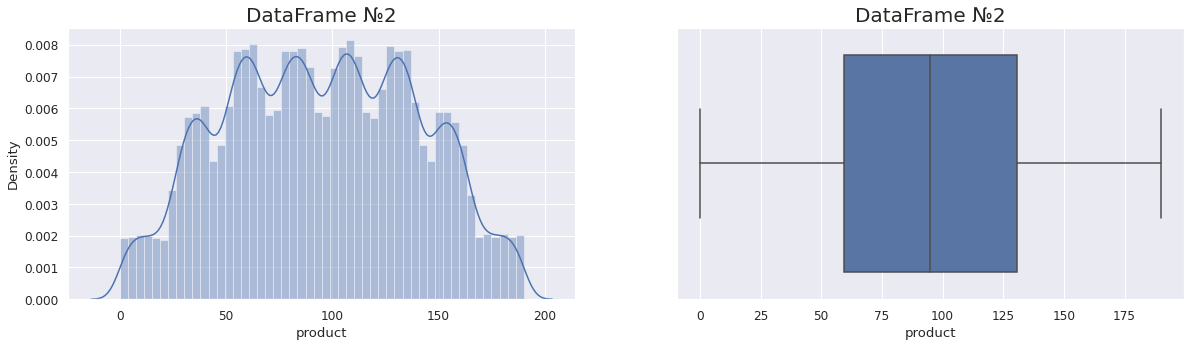

In [42]:
dist_and_box(df,'product')

По предварительному визуальному осмотру, можно предположить, что в районе сбора данные есть несколько тысяч перспективных скважин с мощностью около 175 тыс. баррелей и более. График похож на датасет №0.

Посмотрим на корреляцию

In [43]:
df.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [44]:
#можно визуализировать, но выполняется ооочень долго
#sns.pairplot(data=df2, hue = 'product');

"f2" и "product" имеют слабую 0.445871 корреляцию (но ближе к средней).
У остальных корреляция близка к нулю.

## Обучение и проверка модели

Разобьём данные на обучающую и валидационную выборки в соотношении 75:25
Обучим модель и сделаем предсказания на валидационной выборке
Сохраним предсказания и правильные ответы на валидационной выборке
Покажем средний запас предсказанного сырья и RMSE модели

In [45]:
def get_linear_regression_prediction_grid(df, target_column, get_size_df_split = False):
    
    # выделим признаки
    target = df[target_column]
    features = df.drop([target_column,'id'], axis=1) #если не удалить еще и id то будет ошибка, что текстовое поле
    
    # разобьём данные на тестовую и валидационную выборки в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
    if get_size_df_split:
        print(f'Размеры тренировочной и валидационной выборок {features_train.shape} {features_valid.shape}')
        print(f'Размеры признаков теста и валидации {target_train.shape} {target_valid.shape}')
    
    # обучим модель
    parameters = {'fit_intercept':[True,False], 'copy_X':[True, False], 'normalize':[True,False]}
    model = GridSearchCV(estimator=LinearRegression(), param_grid=parameters, cv=5)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
        
    # посчитаем метрики
    metrics = {}
    metrics['mean_fact_target'] = round(target.mean(),4) # средняя всего фактического сырья
    metrics['mean_predict_valid'] =  round(predicted_valid.mean(),4) # средняя предсказанного сырья
    metrics['mse'] =  round(mean_squared_error(target_valid, predicted_valid),4)
    metrics['rmse'] =  round(metrics['mse'] ** 0.5,4)
    metrics['r2'] =  round(r2_score(target_valid, predicted_valid),4)
    metrics['mae'] =  round(mean_absolute_error(target_valid, predicted_valid),4)
    predicted_valid_for_median = pd.Series(target_train.median(), index=target_valid.index)
    metrics['mae_median'] =  round(mean_absolute_error(target_valid, predicted_valid_for_median),4)
    metrics["best_model_params"] = model.best_params_
    metrics["predicted_valid"] = predicted_valid
    metrics["target_valid"] = target_valid
    
    return metrics

In [46]:
target_column = 'product'

#DataFrame №0
metrics_df0 = get_linear_regression_prediction_grid(df0, target_column)

#DataFrame №1
metrics_df1 = get_linear_regression_prediction_grid(df1, target_column)

#DataFrame №2
metrics_df2 = get_linear_regression_prediction_grid(df2, target_column)

In [47]:
print(f'Средняя предсказанного сырья DataFrame_0: { metrics_df0["mean_predict_valid"] }')
print(f'RMSE DataFrame_0: { metrics_df0["rmse"] }')
print()
print(f'Средняя предсказанного сырья DataFrame_1: { metrics_df1["mean_predict_valid"] }')
print(f'RMSE DataFrame_1: { metrics_df1["rmse"] }')
print()
print(f'Средняя предсказанного сырья DataFrame_2: { metrics_df2["mean_predict_valid"] }')
print(f'RMSE DataFrame_2: { metrics_df2["rmse"] }')
print()

Средняя предсказанного сырья DataFrame_0: 92.5926
RMSE DataFrame_0: 37.5794

Средняя предсказанного сырья DataFrame_1: 68.7285
RMSE DataFrame_1: 0.8931

Средняя предсказанного сырья DataFrame_2: 94.965
RMSE DataFrame_2: 40.0297



Получились такие данные:

DataFrame_0:
Средняя предсказанного сырья: 92.5926
RMSE: 37.5794

DataFrame_1:
Средняя предсказанного сырья: 68.7285
RMSE: 0.8931

DataFrame_2:
Средняя предсказанного сырья: 94.965
RMSE: 40.0297

In [48]:
print(f'Параметры лучше модели DataFrame_0: { metrics_df0["best_model_params"] }')
print()
print(f'Параметры лучше модели DataFrame_1: { metrics_df1["best_model_params"] }')
print()
print(f'Параметры лучше модели DataFrame_2: { metrics_df2["best_model_params"] }')

Параметры лучше модели DataFrame_0: {'copy_X': True, 'fit_intercept': True, 'normalize': True}

Параметры лучше модели DataFrame_1: {'copy_X': True, 'fit_intercept': True, 'normalize': True}

Параметры лучше модели DataFrame_2: {'copy_X': True, 'fit_intercept': True, 'normalize': True}


Анализ полученных результатов

Чем ближе корень из средней квадратичной ошибки (RMSE) к нулю тем лучше.

Наши значения RMSE:

DataFrame_0 RMSE: 37.5794
DataFrame_1 RMSE: 0.8931
DataFrame_2 RMSE: 40.0297

Чтобы понимать много это или мало, обычно MSE предсказаний сравнивают со средним MSE по выборке. Чтобы это постоянно не делать, есть метрика коэффициент детерминации R2. Который равен 1 - MSE/MSEсреднее. Чем R2 ближе к единице тем лучше.

Наши значения R2:

DataFrame_0 R2: 0.2799
DataFrame_1 R2: 0.9996
DataFrame_2 R2: 0.2052

В нулевом и втором дата фрейме R2 довольно низкие. А в DataFrame_1 R2 = 0.9996 как и предсказывалось во время анализа на первом шаге, такой высокий коэффициент скорей всего из-за очень сильной связи целевого показателя с признаком 'f2'.

Метрика MAE среднее абсолютное отклонение так же как и RMSE чем ближе к нулю тем лучше. И при сравнении с медианным MAE наша полученная по предсказаниям модели лучше, особенно в DataFrame_1.

Наши значения MAE:

DataFrame_0 MAE: 30.9196
DataFrame_1 MAE: 0.7188
DataFrame_2 MAE: 32.7927

Модель хорошо предсказывает мощность скважины в тыс.баррелей, отклонения по регионам от 0,04 до 0,14%.

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных

Вводные для расчета прибыли:

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [49]:
count_of_wells = 200

Бюджет на разработку скважин в регионе — 10 млрд рублей.

In [50]:
budget = 10_000_000_000

Цена одной скважины — 50 млн рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [52]:
price_one_thousand_barrels = 450_000

In [53]:
region_df0 = pd.DataFrame(metrics_df0["target_valid"])
region_df0['predicted'] = metrics_df0["predicted_valid"]
region_df0['profit'] = metrics_df0["target_valid"] * price_one_thousand_barrels
region_df0['region'] = 0
print(region_df0.shape)
region_df1 = pd.DataFrame(metrics_df1["target_valid"])
region_df1['predicted'] = metrics_df1["predicted_valid"]
region_df1['profit'] = metrics_df1["target_valid"] * price_one_thousand_barrels
region_df1['region'] = 1

region_df2 = pd.DataFrame(metrics_df2["target_valid"])
region_df2['predicted'] = metrics_df2["predicted_valid"]
region_df2['profit'] = metrics_df2["target_valid"] * price_one_thousand_barrels
region_df2['region'] = 2

(25000, 4)


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе

In [54]:
sufficient_volume = math.ceil(price_one_well / price_one_thousand_barrels)
sufficient_volume

112

In [55]:
oil_reserve = pd.concat([region_df0, region_df1, region_df2])
oil_reserve.pivot_table(index='region')

,predicted,product,profit
region,,,
0,92.592568,92.078597,4.143537e+07
1,68.728547,68.723136,3.092541e+07
2,94.965046,94.884233,4.269790e+07


Всего в одном регионе бюджет в 10 млрд.руб. выделяют для разработки 200 наиболее перспективных скважин с затратами 50 милн.руб. на одну скважину. При существующем уровне цен в 450 тыс.руб. за тыс.баррелей, безубыточная добыча начинается со скважин с запасом в 112 тыс.баррелей. По предсказаниям в среднем такого объема нет ни в одном регионе.

## Расчёт прибыли и рисков 

Выберем скважины с максимальными значениями предсказаний

In [56]:
max_pred_df0 = region_df0.sort_values(by='predicted', ascending=False)[:200]
max_pred_df0

,product,predicted,profit,region
93073,162.810993,180.180713,7.326495e+07,0
46784,153.639837,176.252213,6.913793e+07,0
78948,162.153488,175.850623,7.296907e+07,0
43388,96.893581,175.658429,4.360211e+07,0
6496,178.879516,173.299686,8.049578e+07,0
...,...,...,...,...
30488,179.683422,148.507064,8.085754e+07,0
98799,95.396917,148.481767,4.292861e+07,0
53840,160.361464,148.476498,7.216266e+07,0
4638,102.186603,148.436761,4.598397e+07,0


In [57]:
max_pred_df1 = region_df1.sort_values(by='predicted', ascending=False)[:200]
max_pred_df1

,product,predicted,profit,region
38665,137.945408,139.818970,6.207543e+07,1
20191,137.945408,139.773423,6.207543e+07,1
14041,137.945408,139.703330,6.207543e+07,1
24274,137.945408,139.560938,6.207543e+07,1
92782,137.945408,139.516754,6.207543e+07,1
...,...,...,...,...
13370,137.945408,138.421423,6.207543e+07,1
45823,137.945408,138.416960,6.207543e+07,1
86987,137.945408,138.413881,6.207543e+07,1
72313,137.945408,138.412834,6.207543e+07,1


In [58]:
max_pred_df2 = region_df2.sort_values(by='predicted', ascending=False)[:200]
max_pred_df2

,product,predicted,profit,region
98619,175.103291,165.856833,7.879648e+07,2
46649,131.627481,165.679685,5.923237e+07,2
82661,141.160070,163.439962,6.352203e+07,2
53151,159.676082,162.062589,7.185424e+07,2
18747,142.135203,161.797476,6.396084e+07,2
...,...,...,...,...
66244,104.949568,142.490763,4.722731e+07,2
34285,89.492500,142.485922,4.027162e+07,2
36778,184.895101,142.465777,8.320280e+07,2
7806,137.480469,142.454763,6.186621e+07,2


Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

In [59]:
sum_oil_df0 = math.floor(max_pred_df0['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_0: { sum_oil_df0 } тыс.баррелей')
sum_oil_df1 = math.floor(max_pred_df1['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_1: { sum_oil_df1 } тыс.баррелей')
sum_oil_df2 = math.floor(max_pred_df2['product'].sum())
print(f'Целевое значение объёма сырья DataFrame_2: { sum_oil_df2 } тыс.баррелей')

Целевое значение объёма сырья DataFrame_0: 29601 тыс.баррелей
Целевое значение объёма сырья DataFrame_1: 27589 тыс.баррелей
Целевое значение объёма сырья DataFrame_2: 28245 тыс.баррелей


Рассчитаем прибыль для полученного объёма сырья в млрд. руб.

In [60]:
profit_df0 = round(((sum_oil_df0 * price_one_thousand_barrels) - budget)/1_000_000_000,4)
print('Прибыль для полученного объёма сырья DataFrame_0: {:.4f} млрд.руб.'.format(profit_df0))
profit_df1 = round(((sum_oil_df1 * price_one_thousand_barrels) - budget)/1_000_000_000,4)
print('Прибыль для полученного объёма сырья DataFrame_1: {:.4f} млрд.руб.'.format(profit_df1))
profit_df2 = round(((sum_oil_df2 * price_one_thousand_barrels) - budget)/1_000_000_000,4)
print('Прибыль для полученного объёма сырья DataFrame_2: {:.4f} млрд.руб.'.format(profit_df2))

Прибыль для полученного объёма сырья DataFrame_0: 3.3205 млрд.руб.
Прибыль для полученного объёма сырья DataFrame_1: 2.4150 млрд.руб.
Прибыль для полученного объёма сырья DataFrame_2: 2.7102 млрд.руб.


Выводы
Отобрали по 200 скважин в каждом регионе с наибольшей мощностью которую предсказала модель. Просуммировали реальные данные по этим скажинам. Посчитали прибыль путём вычитания из всех денег которые принесут все скважины, бюджета на разработку в данном регионе. По предварительным данным в каждой регионе прибыль от разработки от 2,4 до 3,32 миллиарда рублей.

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [61]:
def get_values(df):
    global budget
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000): 
        data = df.sample(n=500, random_state=state, replace=True)
        max_pred = data.sort_values(by='predicted', ascending=False)[:200]
        income = (max_pred['profit'].sum() - budget)/1_000_000_000
        values.append(income)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    hight = values.quantile(0.975)
    loss = values[values<0]
    mean = values.mean()
    print("Средняя прибыль: {:.6f} млрд.руб.".format(mean))
    print("2,5%-квантиль: {:.6f} млрд.руб.".format(lower))
    print("97,5%-квантиль: {:.6f} млрд.руб.".format(hight))
    print("Количество убыточных экспериментов:", loss.count())
    print("Вероятность убытков: {:.2%}".format(loss.count()/len(values)))
    print("Максимальный убыток:", loss.min())
    print("Максимальная прибыль:", values.max())
    print("Количество экспериментов:", len(values))

In [62]:
print('Регион DataFrame_0:')
get_values(region_df0)

Регион DataFrame_0:
Средняя прибыль: 0.396165 млрд.руб.
2,5%-квантиль: -0.111216 млрд.руб.
97,5%-квантиль: 0.909767 млрд.руб.
Количество убыточных экспериментов: 69
Вероятность убытков: 6.90%
Максимальный убыток: -0.3695671193500767
Максимальная прибыль: 1.3492668656302222
Количество экспериментов: 1000


In [63]:
print('Регион DataFrame_1:')
get_values(region_df1)

Регион DataFrame_1:
Средняя прибыль: 0.456045 млрд.руб.
2,5%-квантиль: 0.033821 млрд.руб.
97,5%-квантиль: 0.852289 млрд.руб.
Количество убыточных экспериментов: 15
Вероятность убытков: 1.50%
Максимальный убыток: -0.1922681091210556
Максимальная прибыль: 1.1540472794043521
Количество экспериментов: 1000


In [64]:
print('Регион DataFrame_2:')
get_values(region_df2)

Регион DataFrame_2:
Средняя прибыль: 0.404404 млрд.руб.
2,5%-квантиль: -0.163350 млрд.руб.
97,5%-квантиль: 0.950360 млрд.руб.
Количество убыточных экспериментов: 76
Вероятность убытков: 7.60%
Максимальный убыток: -0.4178569542016144
Максимальная прибыль: 1.3305932187701168
Количество экспериментов: 1000


Вывод

Судя по данным если брать 500 скважин произвольным образом, и из них 200 то в любом регионе прибыль будет, но не такая высокая как если брать по предсказанным моделью:

Прибыль DataFrame_0: 3.3205 млрд.руб.
Прибыль DataFrame_1: 2.4150 млрд.руб.
Прибыль DataFrame_2: 2.7102 млрд.руб.

По предсказанию модели лидер по прибыли DataFrame_0: 3.3205 млрд.руб.

У региона с DataFrame_1 вероятность убытков всего 1.5% и в пределах доверительного интервала 95% добыча все равно остаётся без убыточной, тем более средняя прибыль выше чем в других регионах:

Средняя прибыль DataFrame_0: 0.396165 млрд.руб.
Средняя прибыль DataFrame_1: 0.456045 млрд.руб. Средняя прибыль DataFrame_2: 0.404404 млрд.руб.

Общие выводы работы
На первом шаге, провели разведочный анализ, посмотрели на данные, построили графики. Проверка на корреляцию показала в DataFrame_1 очень сильную связь между целевым признаком и признаком-столбцом "f2".

Далее была разработана и обучены три модели Линейной регрессии, параметры подобраны с помощью GridSearchCV для каждого датасета.
